# DSA 5101 Project 1 Code 

## Part 1: Preface
For this project, we will use basic functionalities provided by the machine learning library `scikit-learn`.

We will also need `pandas`, `numpy` and plotting libraries `matplotlib`, `scipy` , `imblearn`, `seaborn`, `hyperopt`, and `xgboost`.


In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

## Part 2: Data Pre-Processing

### Read datasets:

In [3]:
# import training and test dataset
train_data = pd.read_csv('trainingdata.txt', sep=";", header=None)
train_data = train_data.rename(columns=train_data.iloc[0]).loc[1:]

test_data = pd.read_csv('testdata.txt', sep=";", header=None)
test_data = test_data.rename(columns=test_data.iloc[0]).loc[1:]

In [4]:
# convert data type
convert_dict = {'age': int,
                'balance': int,
                'day': int,
                'duration': int,
                'campaign': int,
                'pdays': int,
                'previous': int,
                }
train_data = train_data.astype(convert_dict)
test_data = test_data.astype(convert_dict)

In [5]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
2,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
3,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no
4,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown,no
5,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown,yes


In [6]:
# numerical variables statistics
train_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,40.942076,1365.055989,15.778534,258.363166,2.769907,39.749889,0.579601
std,10.616610,3098.191637,8.313360,257.188052,3.119367,99.547099,2.384831
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1422.250000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


We take a look at the correlation heatmap. Then we examine the impact of different features on the final result *y*

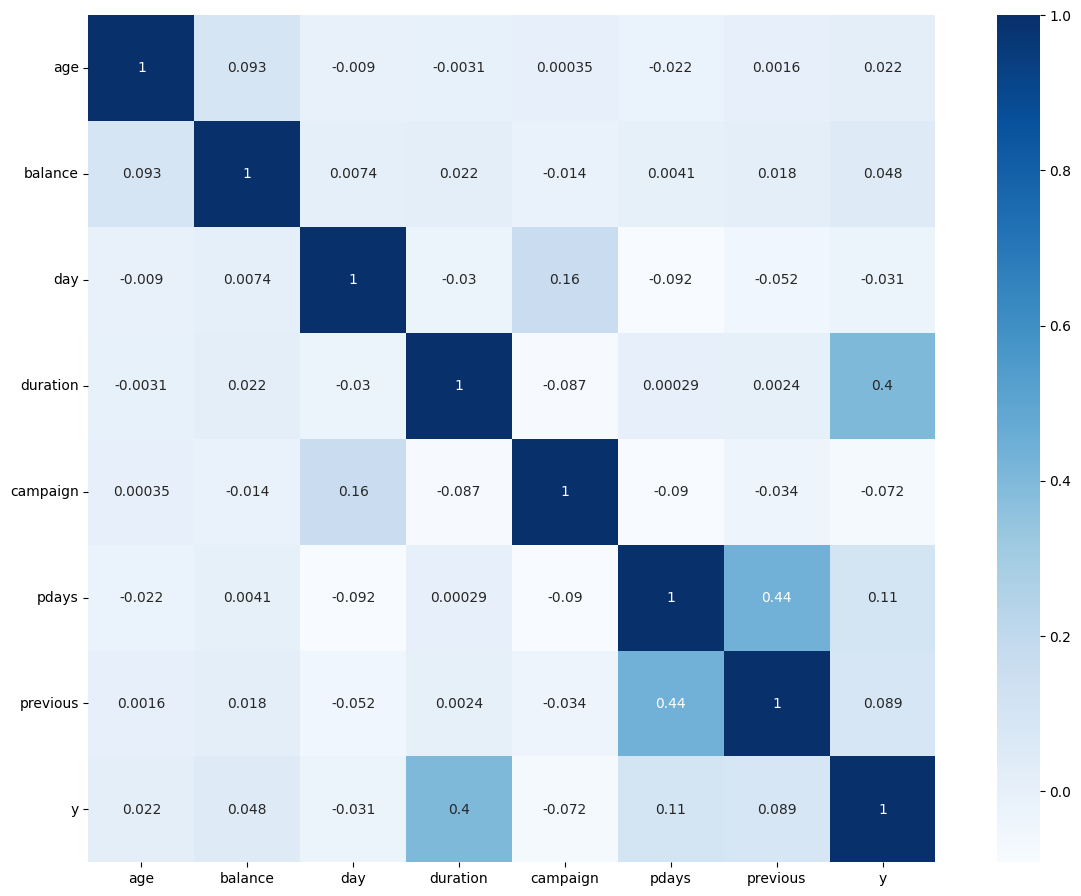

In [7]:
# correlation heatmap
corr_train_data = train_data.copy()
corr_train_data['y'] = corr_train_data['y'].replace(['no', 'yes'],[0, 1], inplace = False)
fig, ax = plt.subplots(figsize=(16,11))
corr = corr_train_data.corr()
sns.heatmap(corr, cmap="Blues", annot=True, square=True, ax = ax)
plt.yticks(rotation=0)
plt.show()

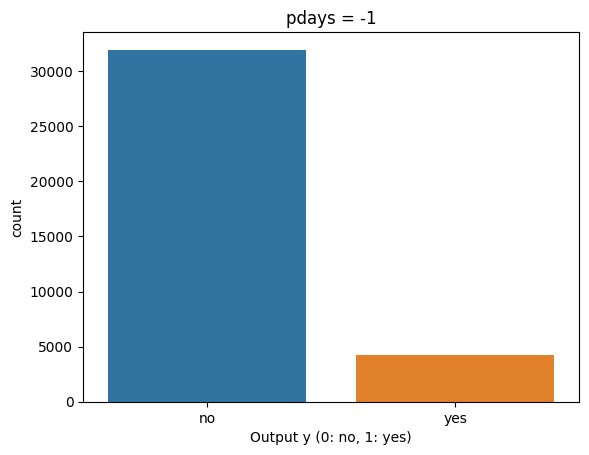

In [8]:
# explore effect of pdays = -1 on output (clients who were not contacted in previous campaigns)
sns.countplot(x = train_data.y.values, data=train_data[train_data['pdays'] == -1])
plt.xlabel("Output y (0: no, 1: yes)")
plt.ylabel("count")
plt.title("pdays = -1")
plt.show()

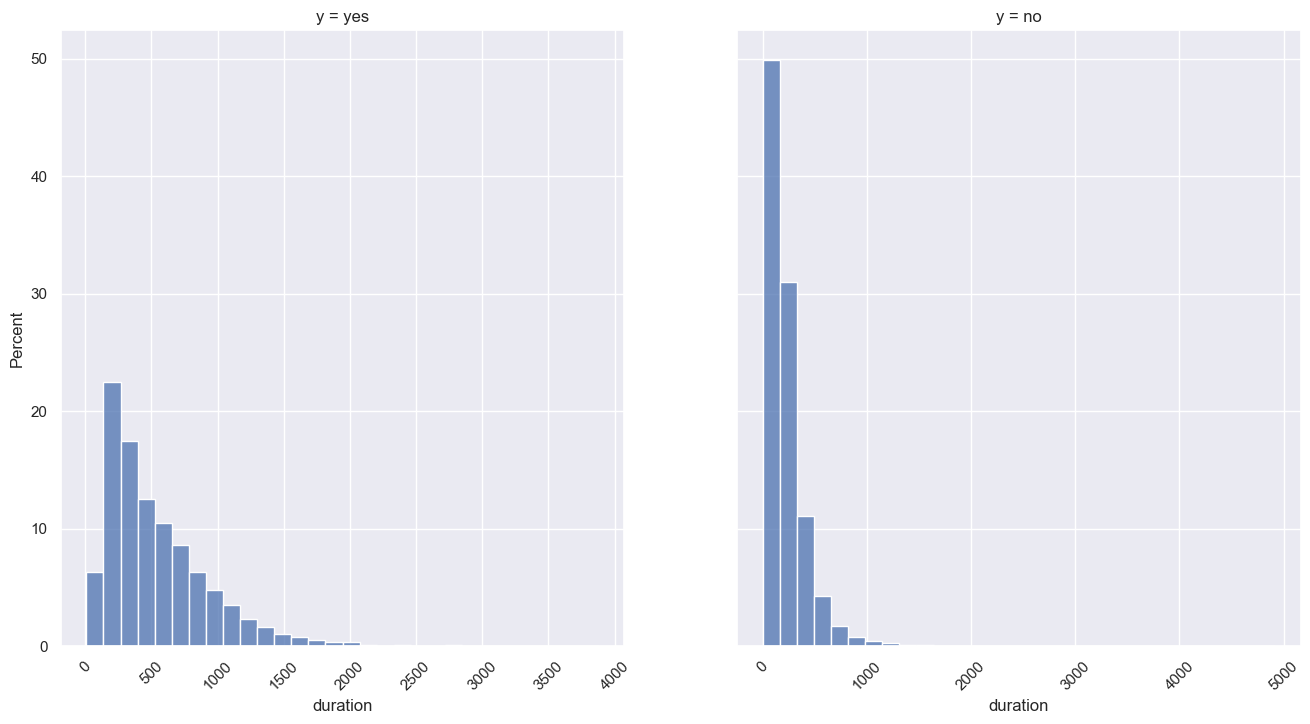

In [9]:
# explore how duration affects output
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey='row')

sns.histplot(
    x='duration',
    data=train_data[train_data.y == 'yes'],
    ax=ax[0],
    bins = 30,
    stat='percent'
)

sns.histplot(
    x='duration',
    data=train_data[train_data.y == 'no'],
    ax=ax[1],
    bins = 30,
    stat='percent'
)

ax[0].set(title = 'y = yes')
ax[1].set(title = 'y = no')

for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)

plt.show()

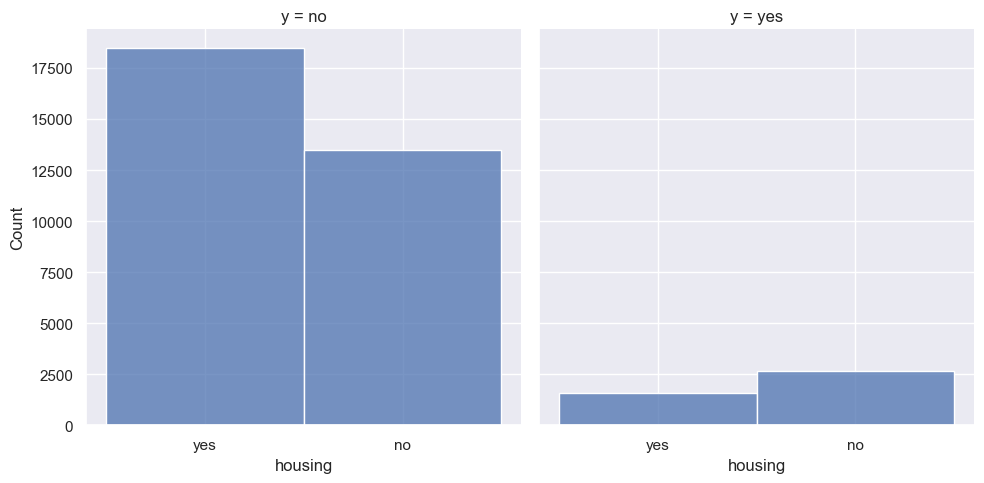

In [10]:
# explore whether clients' housing loan would affects their decision on subscription
sns.displot(data = train_data, x = 'housing', col = train_data['y']);
plt.show()

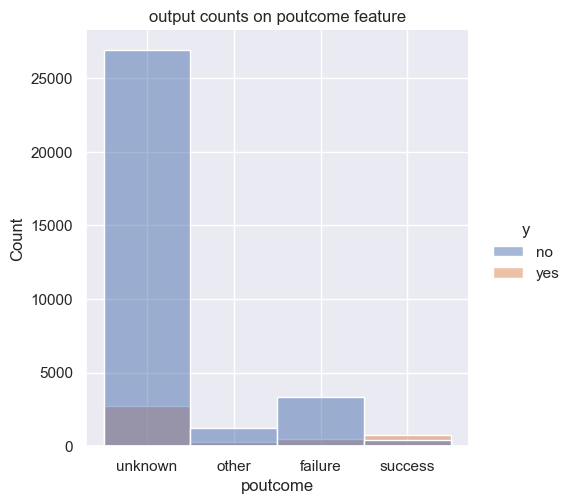

In [11]:
# explore how previous subcriptions affect current campaign
sns.displot(data = train_data, x = 'poutcome', hue = train_data['y']);
plt.title('output counts on poutcome feature')
plt.show()

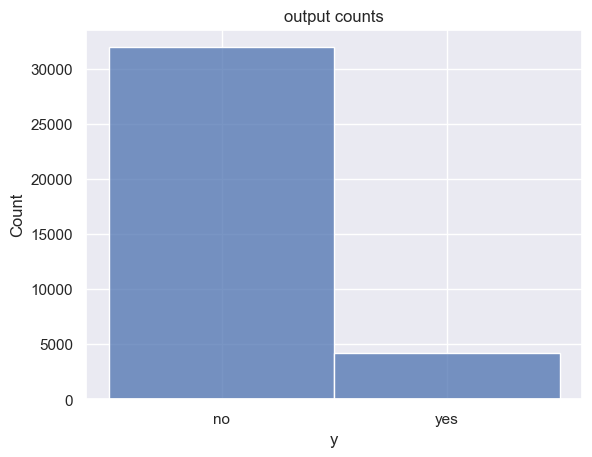

In [12]:
# explore minority class
sns.histplot(train_data["y"]);
plt.title('output counts')
plt.show()

### Feature Selection and Processing
We decide to remove the features "*age*", "*day*", "*month*", "*campaign*", and "*contact*" after we examine the training datasets. Then for binary and categorical features, including "*default*", "*housing*", "*loan*", "*job*", "*matrital*", *education*" and "*poutcome*", we transform them through encoding. 

In [13]:
# training data pre-processing

# remove columns
train_data = train_data.drop(columns=['age', 'day', 'month', 'contact', 'campaign'])

# binary columns processing
train_data['default'].replace(['no', 'yes'],[0, 1], inplace=True)
train_data['housing'].replace(['no', 'yes'],[0, 1], inplace=True)
train_data['loan'].replace(['no', 'yes'],[0, 1], inplace=True)
train_data['y'].replace(['no', 'yes'],[0, 1], inplace=True)

# one hot encoding categorical columns
train_data = pd.get_dummies(train_data, columns=['job', 'marital', 'education', 'poutcome'], \
                            prefix=['job', 'marital', 'edu', 'poutcome'])

### Pre-process Dataset
After transforming the selected features, we then need to remove the outliers, such that out model will not be affected by them. We checked the data and found out that only "*balance*" and "*duration*" features have outliers.

Finally, since the training dataset contains a small number of "*yes*" class for *y*, it is necessaery to do oversampling for *yes* class. In this case, we choose SMOTE to process thr data

In [14]:
# remove outliers for balance, duration, and previous columns using absolute z score
train_data = train_data[(np.abs(stats.zscore(train_data.balance)) < 3)]
train_data = train_data[(np.abs(stats.zscore(train_data.duration)) < 3)]
train_data = train_data[(np.abs(stats.zscore(train_data.previous)) < 3)]


# oversampling using SMOTE
x_train = train_data.drop(columns = ['y'])
y_train = train_data['y']
sm = SMOTE()
x_train_oversampled, y_train_oversampled = sm.fit_resample(x_train, y_train)
train_data_oversampled = pd.concat([x_train_oversampled, y_train_oversampled], axis=1)

train_data_processed = train_data_oversampled

Previous section is applying data pre-processing on training dataset. Next we apply the same steps on test dataset, except for the SMOTE oversampling, since it is only needed for training 

In [15]:
# test data pre-processing

# remove columns
test_data = test_data.drop(columns=['age', 'day', 'month', 'contact', 'campaign'])

# binary columns processing
test_data['default'].replace(['no', 'yes'],[0, 1], inplace=True)
test_data['housing'].replace(['no', 'yes'],[0, 1], inplace=True)
test_data['loan'].replace(['no', 'yes'],[0, 1], inplace=True)
test_data['y'].replace(['no', 'yes'],[0, 1], inplace=True)

# one hot encoding categorical columns
test_data = pd.get_dummies(test_data, columns=['job', 'marital', 'education', 'poutcome'], \
                            prefix=['job', 'marital', 'edu', 'poutcome'])

test_data_processed = test_data

In [16]:
train_data_processed

,default,balance,housing,loan,duration,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,marital_single,edu_primary,edu_secondary,edu_tertiary,edu_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
0,0,-78,1,1,10,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,106,1,0,388,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,407,1,0,67,-1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,952,1,0,62,-1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,364,0,0,306,-1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61617,0,254,0,0,207,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
61618,0,413,0,0,236,182,3,0,0,0,...,0,0,0,0,0,0,0,1,0,1
61619,0,508,0,0,114,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
61620,0,866,0,0,259,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [17]:
test_data_processed

,default,balance,housing,loan,duration,pdays,previous,y,job_admin.,job_blue-collar,...,marital_married,marital_single,edu_primary,edu_secondary,edu_tertiary,edu_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
1,0,468,1,0,220,-1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,0,10215,0,0,139,-1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3,0,900,1,0,213,-1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,1
4,0,1231,0,0,21,-1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,1
5,0,5301,0,0,937,-1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9039,0,1,1,1,162,-1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
9040,0,175,1,0,50,364,2,0,0,1,...,1,0,0,1,0,0,1,0,0,0
9041,0,1873,1,0,192,-1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,1
9042,0,61,1,0,182,-1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1


After data is pre-processed, we proceed to build models based on the datasets

## Part 3 Models:
We have built 3 models to predict the result of *y*, including logistic regression, random forest, as well as boosting method. Their performance will be analysed according to precision, recall, F-measure on yes class, and accuracy on both training and test dataset. 

Before building the model, we first separate the features and *y* from the datasets:

In [18]:
df_inputs = train_data_processed.drop('y', axis=1)
inputs = list(df_inputs.columns)
outputs = 'y'

X_train = train_data_processed.drop(columns=["y"])
X_test = test_data_processed.drop(columns=["y"])

y_train = train_data_processed["y"]
y_test = test_data_processed["y"]

## Logistic regression:
We build the model using `LogisticRegression` module from `sklearn` package

### Build model:

In [19]:
from sklearn.linear_model import LogisticRegression

# do logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

Take a look at the coefficients and intercept of the logistic regression model

In [20]:
lr.coef_

array([[-2.50103043e-01,  8.85197003e-05, -1.65097414e+00,
        -1.74309161e+00,  5.70235806e-03,  9.79918938e-03,
        -1.19279718e-01, -1.16957037e+00, -2.05076134e+00,
        -7.65781202e-01, -7.59240902e-01, -1.84817905e+00,
        -8.90104364e-01, -8.55124435e-01, -1.39498733e+00,
        -3.69763879e-01, -1.84370854e+00, -7.10428643e-01,
        -2.87910507e-01, -2.17456512e+00, -2.04835904e+00,
        -2.22428376e+00, -2.54202856e+00, -1.50241966e+00,
        -1.92525781e+00, -1.14943824e+00, -1.84717772e+00,
        -9.06529385e-01,  1.38181292e+00,  4.48561723e-01]])

In [21]:
lr.intercept_

array([2.17629218])

### Feature Importance:
We than analyse the importance of each feature in the training dataset. Following is an array anf corresponding visualization of the feature importance

In [22]:
# feature importance
input_coef = {}
for i in range(len(inputs)):
    input_coef[inputs[i]] = lr.coef_[0][i] * np.std(X_train, 0)[i]
# sort by coef abs (feature importance) in descending order
input_coef_sorted = sorted(input_coef.items(), key=lambda x:abs(x[1]), reverse=True)
input_coef_sorted

[('duration', 1.3624291974121858),
 ('pdays', 1.0394219595258756),
 ('marital_married', -1.0211090956966942),
 ('marital_single', -0.9157886954257849),
 ('edu_tertiary', -0.8053292986004051),
 ('housing', -0.7969012828691182),
 ('edu_primary', -0.7328905722013845),
 ('edu_secondary', -0.7305864055341226),
 ('job_blue-collar', -0.6900491662502836),
 ('job_management', -0.6476711546034094),
 ('job_technician', -0.5642953663454673),
 ('marital_divorced', -0.5557522165947486),
 ('loan', -0.5100795858994946),
 ('poutcome_failure', -0.48231430979115253),
 ('poutcome_success', 0.34276360008097806),
 ('job_services', -0.314011504831366),
 ('job_admin.', -0.30046468461183373),
 ('poutcome_unknown', 0.19742375411062932),
 ('edu_unknown', -0.17839982080165023),
 ('balance', 0.15995101944816337),
 ('job_retired', -0.15913625266319784),
 ('previous', -0.1432025002662732),
 ('poutcome_other', -0.1395221145191827),
 ('job_self-employed', -0.12073847585935205),
 ('job_entrepreneur', -0.105253981860099

[Text(0, 0, '1.36243'),
 Text(0, 0, '1.03942'),
 Text(0, 0, '-1.02111'),
 Text(0, 0, '-0.915789'),
 Text(0, 0, '-0.805329'),
 Text(0, 0, '-0.796901'),
 Text(0, 0, '-0.732891'),
 Text(0, 0, '-0.730586'),
 Text(0, 0, '-0.690049'),
 Text(0, 0, '-0.647671'),
 Text(0, 0, '-0.564295'),
 Text(0, 0, '-0.555752'),
 Text(0, 0, '-0.51008'),
 Text(0, 0, '-0.482314'),
 Text(0, 0, '0.342764'),
 Text(0, 0, '-0.314012'),
 Text(0, 0, '-0.300465'),
 Text(0, 0, '0.197424'),
 Text(0, 0, '-0.1784'),
 Text(0, 0, '0.159951'),
 Text(0, 0, '-0.159136'),
 Text(0, 0, '-0.143203'),
 Text(0, 0, '-0.139522'),
 Text(0, 0, '-0.120738'),
 Text(0, 0, '-0.105254'),
 Text(0, 0, '-0.0933465'),
 Text(0, 0, '-0.091511'),
 Text(0, 0, '-0.0428006'),
 Text(0, 0, '-0.0261464'),
 Text(0, 0, '-0.0175186')]

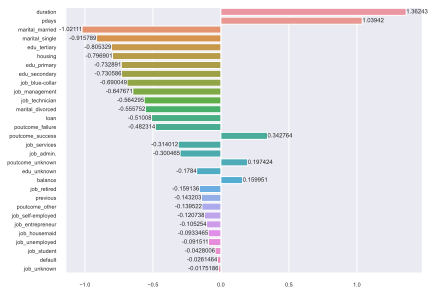

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_theme(font_scale=0.5)
ax = sns.barplot(
    x=[i[1] for i in input_coef_sorted],
    y=[i[0] for i in input_coef_sorted],
    orient='h',
)
ax.bar_label(ax.containers[0])

### Model Performance:
We fist apply the model on the training and test dataset respectively, and examine their performance

In [24]:
# predicted value 
y_hat_train_lr = lr.predict(X_train)
y_hat_test_lr = lr.predict(X_test)

#predicted probability 
prob_pred_train_lr = lr.predict_proba(X_train)[:,1]
prob_pred_test_lr = lr.predict_proba(X_test)[:,1]

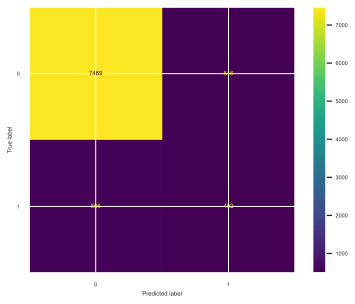

In [25]:
#check recall, precision, F-measure, and accuracy scores
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

plot_confusion_matrix(lr, X_test, y_test)

In [26]:
precision_recall_fscore_support(y_test, y_hat_test_lr, beta=1.0, labels=[1])

(array([0.48809524]), array([0.46502836]), array([0.47628267]), array([1058]))

**For yes class:**
- **Precision**: 0.4793
- **Recall**: 0.5151
- **F-measure**: 0.4966

In [27]:
from sklearn.metrics import accuracy_score

print(
    f'Accuracy Score \
    \nTrain: {accuracy_score(y_train, y_hat_train_lr)} \
    \nTest: {accuracy_score(y_test, y_hat_test_lr)}'
)

Accuracy Score     
Train: 0.9138457044562007     
Test: 0.8803494415570055


## Random Forest

We build the model using `RandomForestClassifier` module from `sklearn` package.

### Build Model:

Here are the specifications of this model:

Criterion: Gini index \
Max_depth: None (until all leaves are pure) \
Min_sample_split: 2 (The minimum number of samples required to split an internal node)\
n_estimators: 100 (number of random trees)\
max_features: n/3 = 10 (maximum number of variables picked each time, n refers to number of parameters

In [28]:
from sklearn.ensemble import RandomForestClassifier

#build random forest classification model
rf = RandomForestClassifier(min_samples_split=2,random_state=0, n_estimators = 100, max_features=10, min_samples_leaf=1, criterion="gini")

In [29]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=10, random_state=0)

### Feature Importance

In [30]:
importances_rf = rf.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances_rf)[::]
importances_rf[sorted_indices]

array([0.00104868, 0.00233863, 0.00304317, 0.0055009 , 0.00565346,
       0.00630937, 0.00728243, 0.00746116, 0.00777754, 0.01115818,
       0.01142839, 0.01177913, 0.01198089, 0.01409302, 0.01890938,
       0.01947376, 0.0198701 , 0.02209856, 0.02393618, 0.02441112,
       0.02538794, 0.02891533, 0.03358641, 0.03667942, 0.03668801,
       0.04256651, 0.04342041, 0.09090722, 0.12568541, 0.30060931])

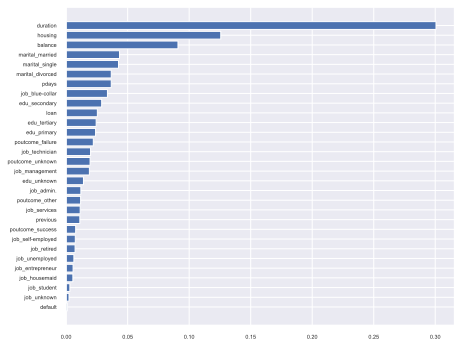

In [31]:
plt.barh(range(X_train.shape[1]), importances_rf[sorted_indices], align='center')
plt.yticks(range(X_train.shape[1]), train_data_processed.columns[sorted_indices])
plt.tight_layout()
plt.show()

### Model Performance

In [32]:
#predict result using the model and training dataset X_train
y_hat_train_rf = rf.predict(X_train)

#predict result using the model and test dataset X_test
y_hat_test_rf = rf.predict(X_test)

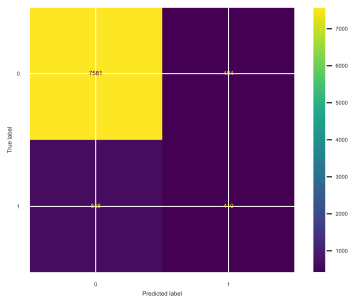

In [33]:
#confusion matrix
plot_confusion_matrix(rf, X_test, y_test)

In [34]:
#compute recall, precision, and F-measure for yes class
precision_recall_fscore_support(y_test, y_hat_test_rf, beta=1.0, labels=[1])

(array([0.5036855]), array([0.38752363]), array([0.43803419]), array([1058]))

**For yes class:**
- **Precision**: 0.5025
- **Recall**: 0.3866
- **F-measure**: 0.4370

In [35]:
print(f"Accuracy: \n\
        Train: {accuracy_score(y_train, y_hat_train_rf)} \n\
        Test: {accuracy_score(y_test, y_hat_test_rf)}")

Accuracy: 
        Train: 0.9998864042062899 
        Test: 0.8836669246931328


## XGBoost

We build the model using `GradientBoostingClassifier` module from `sklearn` package, and `xgboost` package

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from sklearn.model_selection import train_test_split

#split the training dataset
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

#set specifications for the boost model
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

We define a function for us to build the boosting model with different parameters

In [39]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
                    random_state = 42)
    
    evaluation = [(X_train_xgb, y_train_xgb), (X_val_xgb, y_val_xgb)]
    
    clf.fit(X_train_xgb, y_train_xgb,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_val_xgb)
    accuracy = accuracy_score(y_val_xgb, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

Next, we find the best hyperparameters

In [40]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                          
0.8824579434197003                                                              
SCORE:                                                                          
0.9083680424081787                                                              
SCORE:                                                                          
0.9069075566614377                                                              
SCORE:                                                                          
0.8830529561313355                                                              
SCORE:                                                                          
0.8819711148374534                                                              
SCORE:                                                                          
0.9055011629793909                                                              
SCORE:                      

0.9076648455671553                                                              
SCORE:                                                                          
0.9088548709904257                                                              
SCORE:                                                                          
0.9029047438740737                                                              
SCORE:                                                                          
0.9065830042732731                                                              
SCORE:                                                                          
0.9063125439498025                                                              
SCORE:                                                                          
0.9064748201438849                                                              
SCORE:                                                                          
0.8796992481203008          

In [41]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6821974151579411, 'gamma': 5.2896062043515775, 'max_depth': 3.0, 'min_child_weight': 4.0, 'reg_alpha': 41.0, 'reg_lambda': 0.8831826593108782}


In [42]:
best_hyperparams["max_depth"] = int(best_hyperparams["max_depth"])

Train the model using training set X_train and y_train

In [43]:
xgb_clf = xgb.XGBClassifier(**best_hyperparams, random_state = 42)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6821974151579411, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=5.2896062043515775, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=4.0,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=41.0, reg_lambda=0.8831826593108782, ...)

### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

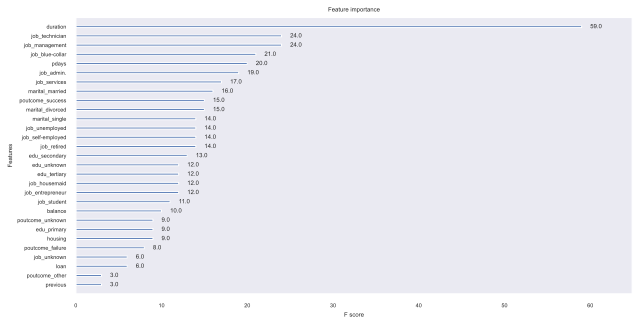

In [44]:
plt.rcParams["figure.figsize"] = (10, 5)
# xgb.plot_importance(xgb_clf, grid = False).set_yticklabels(column_list[1:])
xgb.plot_importance(xgb_clf, grid = False)

### Performance

Apply the model on training and test datasets to analysis its performance

In [45]:
y_hat_train_xgb = xgb_clf.predict(X_train)
y_hat_test_xgb = xgb_clf.predict(X_test)

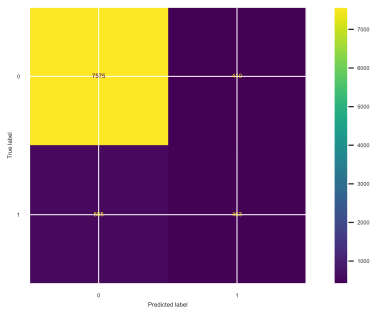

In [46]:
#confusion matrix
plot_confusion_matrix(xgb_clf, X_test, y_test)

In [47]:
#compute recall, precision, and F-measure for yes class
precision_recall_fscore_support(y_test, y_hat_test_xgb, beta=1.0, labels=[1])

(array([0.5303551]), array([0.43761815]), array([0.47954428]), array([1058]))

**For yes class:**
- **Precision**: 0.5641
- **Recall**: 0.3743
- **F-measure**: 0.45

In [48]:
#Accuracy score
print(f"Accuracy: \n\
        Train: {accuracy_score(y_train, y_hat_train_xgb)} \n\
        Test: {accuracy_score(y_test, y_hat_test_xgb)}")

Accuracy: 
        Train: 0.9347148745577878 
        Test: 0.8888643149397324
